___
<img style="float: right; margin: 0px 0px 15px 15px;" src="https://www.carrerasenlinea.mx/logos/original/logo-instituto-tecnologico-y-de-estudios-superiores-de-occidente.png" width="150px" height="100px" />

# <font color = darkred> Microestructuras y Sistema de Trading
## Laboratorio 1: Administración activa Vs Administración pasiva del capital.
### Fecha: 12/Septiembre/2019

### Equipo A:
* Tere Castillo Flores
* Ana Laura Correa Cabrales
* Gaspar Benitez Fregoso
* Marysol Cantarero Velazquez del Valle

### <font color = navy> Situación
Acabas de entrar a trabajar a una operadora de fondos de inversión como analista financiero dentro de la mesa de análisis del mercado de renta variable. En la junta trimestral se plantea la posibilidad de crear un fondo propio con exposición al mercado de valores de USA tratando de replicar a los ETFs conocidos como ishares que la empresa BlackRock ofrece. 

La idea es replicar un ETF con posiciones en directo. Te han asignado la tarea de hacer un ejercicio simple de replicar la construcción de un portafolio de inversión y un criterio de rebalanceo lo más parecido a un ETF de ishares que tu selecciones. Esto con la finalidad de comparar los resultados de haber rebalanceado periódicamente el portafolio, ó, no haberlo hecho y continuar todo un año con las mismas posiciones.


### <font color = navy> Características mínimas de solución
Debido a tu formación, te piden que este proceso que construyas sea repetible para cualquier ETF y también incluir 3 medidas de atribución al desempeño, tanto para el caso que el ETF nunca hubiese sido rebalanceado como para los casos donde sí. 

En la mesa de análisis están interesados en conocer el proceso que sigues para adquirir, limpiar, dar formato y utilizar los datos, y a pesar que el equipo senior de análisis está compuesto por personal altamente calificado en temas de economía y finanzas, ellos no saben programar por lo que te piden que incluyas el código utilizado, y que sea de manera ordenada y explicando el sentido de las funciones y paqueterías que requeriste. 

* Comparar con 1 año de información: 01/Marzo/2017 al 01/Marzo/2018 

* Utilizar un ETF de Ishares para el mercado de renta varialbe de USA 

* Entregar un Jupyter Notebook con explicación y comentarios en el código 

* Crear y actualizar continuamente un repositorio en GitHub para el proyecto.

### <font color = navy> Resolución del problema

Los ETF(Exchange Trade Funds) son fondos o instrumentos de inversión cuyos títulos cotizan en la bolsa, al igual que una acción bursátil,pudiendose comprar y vender en cualquier momento, sin necesidad de esperar al cierre del mercado. Su objetivo es replicar el comportamiento de los activos que componen un índice bursátil, ya sea de renta fija, variable, divisas o materias primas u otros activos financieros.

Para este problema se analizara el ETF "iShares U.S. Financials ETF (IYF)" para el mercado de renta variable de USA con posiciones en directo tomando información del 01/Marzo/2018 al 01/Marzo/2019. Sin embargo, el código a realizar debe ser repetible para cualquier ETF.

Las 3 medidas de atribución al desempeño que se eligieron para la comparación de los resultados son:
* Rendimiento: utilidad en relación con lo que se ha invertido.Entre mayor sea este mejor.
* Volatilidad: medida de la intensidad de los cambios del precio de un activo en un tipo definido. Se usa con frecuencia para cuantificar el riesgo.Entre menor sea este mejor.
* Sharpe: =  es una variable que sirve para valorar la calidad de un fondo de inversión, es decir,que tanto se compensa un inversor al asumir un riesgo. En definitiva, el ratio de Sharpe mide exactamente la relación entre ambos factores: rentabilidad y riesgo. Entre mayor sea, mejor es la rentabilidad del fondo en relación a la cantidad de riesgo que se ha tomado en la inversión.

### <font color = orange> Librerias

In [111]:
# Descarga de librerías
import quandl
import datetime
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
from plotly.subplots import make_subplots
import plotly.graph_objects as go

### <font color = orange> Llave de Quandl, numero de archivos, fechas y tasas

In [2]:
quandl.ApiConfig.api_key = "My9ygJsz7yTDx_9jcneH"  # API key Quandl
narch = 13
fechas = list(['2017-02-28', '2017-03-31', '2017-04-28', '2017-05-31', '2017-06-30',
                 '2017-07-31', '2017-08-31', '2017-09-29', '2017-10-31', '2017-11-30',
                 '2017-12-29', '2018-01-31', '2018-02-28'])
tl = [0.4, 0.74, 0.68, 0.86 , 0.84, 1, 0.95, 0.96, 0.99 , 1.14 ,0.28 , 1.43, 1.5]

### <font color = orange> Declaración de funciones

### <font color = navy> Descarga de datos

In [3]:
# Función para descarga de los archivos csv los holdings del, sus tickers y
# los shares oustanding (número de acciones en circulación).
def holdings_csv(narch,name):
    #Lista para guardar informacion
    holdings = []
    tickers = []
    shares = []
    for i in range(narch):
        r = name+str(i)+".csv"
        info = pd.read_csv(r,header=10, index_col= 0)
        shar = pd.read_csv(r,nrows=7).loc['Shares Outstanding'][0] #.loc nos localiza Shares Outstanding, [0] jala solo el valor numerico
        info = info.dropna() # quitando los datos vacios.
        info = info.drop(columns = ['Name', 'Asset Class', "Market Value", 'Notional Value', 'Sector', 'SEDOL', 'ISIN', 'Exchange'])
        holdings.append(info) #A mi lista le agrego "info"
        tickers.append(list(holdings[i].index)) #A tickers agregar Holdings pero ciclicamente de 1 a 12.
        shares.append(shar) #Jala shares y los agrega a una nueva lista.
    return holdings, tickers, shares #Regresa las 3 listas pero ya con informacion.
holdings, tickers, shares = holdings_csv(narch,"IYF_holdings")#Guarda las listas.

### <font color = navy> Función para descarga de datos históricos y agrupacion de tickers por fecha (Quandl)

In [4]:
# Función para descarga de datos históricos y agrupacion de tickers por fecha (QUANDL)
def download_quandl(fechas, tickers): #Jala los tickers y fechas
    date = {'gte': fechas[0], 'lte': fechas[-1] } #Toma la primer fecha de la lista y la ultima fecha de la lista.
    column = {'columns': ['ticker', 'date', 'Adj_close']} #Que necesito de Quandl
    data = quandl.get_table('WIKI/PRICES', qopts=column, ticker=tickers, date=date, paginate=True)
    data = data.set_index('date')
    data = data.pivot(columns='ticker') # Agrupacion de tickers por fecha 
    data.columns = data.columns.droplevel(0) # Agrupacion de tickers por fecha
    return data

### <font color = navy> Función para convertir de "str" a "float"

In [5]:
def str_to_float(var): #Defines variable
    st=var #Si la variabl es flotante, regresa el mismo valor.
    if type(var[0]) != np.float64: #Si el valor de la variable no es float, comienza el ciclo.
        st=[] # Arranca lista vacia para guardar informacion.
        for i in var: #Para i, agarrara cada valor de la varible, le quitara la "," y la sustituye por un vacio. Tambien convierte la variable en un flotante.
            st.append(float(i.replace(',','')))
    return (st)

### <font color = navy> Función para calcular el rendimiento de las series

In [6]:
def Rend(navN): 
    h =[]# "h" comienza como lista vacia
    for i in range(len(navN)-1): # el (-1) es para que nos permita realizar la iteacion.
        y= np.log(navN[i+1]/navN[i]) #Formula de rendimiento.
        h.append(y) #Va haciendo append a los resultados.
    return h #Nos regresa "h"

### <font color = navy> Función para calcular las medidas de desepeño (Rendimiento, Variación y Sharpe)

In [7]:
#Función para calcular las medidas de desepeño ( Rendimiento, Variación y sharpe)
#def medidas_desempeño(Rend,tl):
#    media = np.mean(Rend) #Media de los rendimientos
#    std = np.std(Rend) #Desv Stndr de los rendimientos
#    sharpe = (media -tl[i]/100)/std #Sharpe
#    return media, std, sharpe #Regresa los resultados

### <font color = orange> Limpieza de la información

In [8]:
# Juntando tickers para hacer un mismo indice
venta=[] 
igual=[] 
compra=[] 
for i in range(narch-1):
    venta.append(list(set(tickers[i])-set(tickers[i+1]))) # Compara listas de tickers, guarda las que se eliminaron
    igual.append(list(set(tickers[i+1])-set((set(tickers[i+1])-set(tickers[i]))))) # Compara tickers, guarda las iguales
    compra.append(list(set(tickers[i+1])-set(tickers[i])))  # Compara tickers, guarda las que se compraron
venta = list(np.concatenate(venta)) #Concatena las ventas
igual = list(np.concatenate(igual)) #Concatena las que estan iguales
compra = list(np.concatenate(compra)) #Concatena las compras
indice = list(set(venta+igual+compra)) #Junta todo el set como un solo indice

In [9]:
# Acomodo de información de acuerdo a índice(tickers) en común (Weight(%), Price y Shares)
Weights , Prices, Shares = pd.DataFrame(index=indice) , pd.DataFrame(index=indice), pd.DataFrame(index=indice)
for i in range(narch):
    l,l1,l2= [],[],[]
    for j in range(len(tickers[i])):
        l.append(holdings[i]['Weight (%)'][tickers[i][j]])
        l1.append(holdings[i]['Price'][tickers[i][j]])
        l2.append(holdings[i]['Shares'][tickers[i][j]])
    l , l1, l2 = pd.DataFrame(l, index=tickers[i]),pd.DataFrame(str_to_float(l1), index=tickers[i]),pd.DataFrame(str_to_float(l2), index=tickers[i])
    Weights['Holdings'+str(i)+''] ,Prices['Holdings'+str(i)+''],Shares['Holdings'+str(i)+''] = l ,l1 , l2

### <font color = orange> Escenarios de Rebalanceos
    
En el primer escenario se replica el etf original para así poder realizar una comparación al final. En los demás escenarios se realizan distintos rebalanceos de la siguiente manera:

- Segundo escenario = [0]
- Tercer escenario = [0,1]
- Cuarto escenario = [0,2]
- ... 
- Ultimo escenario = [0,12]

Explicación: En el segundo escenario no hay rebalanceos, es decir, se mantienen las posiciones iniciales durante todo el año. Del tercer al ultimo escenario únicamente hay un rebalanceo mensual, el cual se va recorriendo mensualmente por escenario.

En total habrá 14 escenarios.


### NAV (Net Asset Value) o VL (Valor liquidativo)

El valor liquidativo es el precio al que el inversor paga las participaciones que adquiere del fondo de inversión que escoja. Además, el valor liquidativo sirve de referencia para conocer la rentabilidad de la inversión y por tanto el beneficio que podrá recibir si el inversor decide vender sus participaciones y dar por finalizada su inversión.

Notas de iShares:
La rentabilidad pasada no es indicativa de la rentabilidad futura y no debe ser el único factor que se considere a la hora de seleccionar un producto. Los datos de rentabilidad se basan en el valor liquidativo (Net Asset Value, NAV) del ETF que puede no ser el mismo que el precio de mercado del ETF. " Los accionistas individuales pueden obtener rendimientos distintos de la rentabilidad del NAV."

###### El valor liquidativo de un fondo de inversión se calcula dividiendo el patrimonio del fondo entre el número de participaciones existentes.

* VL = P / N = Patrimonio neto del fondo(Valor de la Cartera del fondo) / Número de participaciones del fondo.
* El valor de la cartera del fondo es *precios x shares*

In [10]:
precios_qdl = download_quandl(fechas, indice).T  #descarga de precios de quandl
dif =list(set(indice)-set(precios_qdl.index)) #lista con los tickers que no encontro quandl
P=Prices.loc[dif] #Identificando los datos que se tienen de los csv que no encontro quandl
P.columns = pd.to_datetime(fechas) #convirtiendo las columnas en fechas para poder adjuntarlas a los datos de quandl
precios_f= precios_qdl.append(P) #agregando info csv's a precios quandl 
precios_f= precios_f.fillna(0).T  #la información que no se encontro se reemplaza por 0.
precios_f['USD'] = 1 

In [11]:
Agrup = pd.DataFrame(list(precios_f.groupby(pd.Grouper(freq='M')))) #agrupando por mes para poder sacar nav diario
Agrup[1][2].loc['2017-04-14'] = Agrup[1][2].loc['2017-04-13'] # Quitando fecha sin ningun dato y cambiandolo por el dia anterior, esto ya que afecta mucho a la volatilidad si no se hace el cambio

### <font color = teal> Escenario A -  Original

In [12]:
# SERIE ORIGINAL
def nav(narch):
    NAVs_diario= []  # lista vacia donde se guardara el calculo del NAV diario.
    nav_mes = []   # "" NAV último del mes
    Rends_diario=[]  # "" Rendimiento diario
    Rends_mensual=[]  # Rendimientos mensuales
    Dsv_mensual=[]  # Variaciones mensuales
    Sharpe_mensual=[] #Sharpes mensuales
    for i in range(len(Agrup)):
        dif = list(set(indice)-set(tickers[i]))
        g = Agrup[1][i]*Shares['Holdings'+str(i)+'']
        g= (g.T.drop(dif)).T
        h= [sum(g.loc[j])/str_to_float(shares)[i] for j in list(g.index)] 
        NAVs_diario.append(h)
        nav_mes.append(h[-1])
        Rends_diario.append(Rend(h))
        Rends_mensual.append(np.mean(Rend(h)))
        Dsv_mensual.append(np.std(Rend(h)))
        Sharpe_mensual.append((np.mean(Rend(h))-tl[i]/12/100)/np.std(Rend(h)))
    return NAVs_diario,nav_mes,Rends_diario,Rends_mensual[1:],Dsv_mensual[1:],Sharpe_mensual[1:]

In [13]:
NAVs_diario,nav_mes,Rends_diario,Rends_mensual,Dsv_mensual,Sharpe_mensual = nav(narch)

/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [14]:
Agrup[1][2]*Shares['Holdings2']

,ACC,ACGL,AFG,AFL,AFSI,AGNC,AGO,AHL,AIG,AIV,...,WRE,WRI,WTFC,WTM,WU,WY,XHR,XL,Y,ZION
2017-04-03,2.277107e+06,4227058.82,2.438042e+06,1.053401e+07,709816.485893,2.278548e+06,1.753233e+06,1.116335e+06,2.078282e+07,2.494136e+06,...,847496.967563,1.408459e+06,1.297425e+06,11765152.56,3.418184e+06,9.050666e+06,0.0,3.780042e+06,3399296.88,3.066044e+06
2017-04-04,2.288064e+06,4293029.48,2.460490e+06,1.052676e+07,852556.600019,2.296731e+06,1.769270e+06,1.120641e+06,2.091399e+07,2.500889e+06,...,850738.906872,1.408878e+06,1.295523e+06,11723944.32,3.407810e+06,9.117787e+06,0.0,3.810743e+06,3442901.20,3.057970e+06
2017-04-05,2.282823e+06,4252639.28,2.431850e+06,1.046587e+07,783808.300154,2.294458e+06,1.737196e+06,1.105570e+06,2.072564e+07,2.512145e+06,...,848577.613999,1.403013e+06,1.276321e+06,11590450.96,3.399165e+06,9.120472e+06,0.0,3.778124e+06,3413627.20,3.013194e+06
2017-04-06,2.291398e+06,4235585.64,2.443977e+06,1.057606e+07,747686.312089,2.283094e+06,1.794740e+06,1.103417e+06,2.079963e+07,2.524525e+06,...,858033.270316,1.406784e+06,1.305030e+06,11560845.04,3.387062e+06,9.238606e+06,0.0,3.818418e+06,3410448.88,3.046225e+06
2017-04-07,2.275678e+06,4208210.06,2.432366e+06,1.056881e+07,733315.198558,2.278548e+06,1.825400e+06,1.094805e+06,2.063146e+07,2.527902e+06,...,866138.118587,1.403432e+06,1.294002e+06,11477761.76,3.347296e+06,9.359425e+06,0.0,3.820337e+06,3411006.48,3.047693e+06
2017-04-10,2.274725e+06,4229751.50,2.445267e+06,1.066304e+07,732926.790085,2.278548e+06,1.818796e+06,1.100188e+06,2.067855e+07,2.531841e+06,...,867218.765023,1.419771e+06,1.283165e+06,11568046.48,3.357670e+06,9.324522e+06,0.0,3.847200e+06,3417028.56,3.004385e+06
2017-04-11,2.284729e+06,4251292.94,2.457729e+06,1.069204e+07,594264.964933,2.284230e+06,1.803702e+06,1.107723e+06,2.044647e+07,2.521711e+06,...,878835.714212,1.434852e+06,1.295904e+06,11702340.00,3.374959e+06,9.300358e+06,0.0,3.886536e+06,3432418.32,3.005119e+06
2017-04-12,2.295686e+06,4214941.76,2.441679e+06,1.063405e+07,628833.319103,2.283094e+06,1.795684e+06,1.095881e+06,2.023794e+07,2.489634e+06,...,876674.421340,1.439461e+06,1.267765e+06,11510034.88,3.357670e+06,9.284249e+06,0.0,3.870226e+06,3386862.40,2.950067e+06
2017-04-13,2.286634e+06,4176795.46,2.415015e+06,1.058331e+07,603975.176779,2.303549e+06,1.776817e+06,1.080810e+06,2.002940e+07,2.475565e+06,...,871811.512377,1.439042e+06,1.238485e+06,11473227.52,3.345567e+06,9.243976e+06,0.0,3.838566e+06,3338630.00,2.895749e+06
2017-04-14,2.286634e+06,4176795.46,2.415015e+06,1.058331e+07,603975.176779,2.303549e+06,1.776817e+06,1.080810e+06,2.002940e+07,2.475565e+06,...,871811.512377,1.439042e+06,1.238485e+06,11473227.52,3.345567e+06,9.243976e+06,0.0,3.838566e+06,3338630.00,2.895749e+06


### <font color = teal> Graficas

In [142]:
x = fechas
data = go.Scatter(x=x,y= nav_mes, mode= 'lines+markers', name= 'NAV mensual')

layout = go.Layout(title='NAV', xaxis=dict(title='Fechas'),yaxis=dict(title='NAV mensual'))
fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = 'Hist')

In [144]:
x = fechas
data = go.Scatter(x=x,y= Rends_mensual, mode= 'lines+markers', name= 'Rendimiento mensual')

layout = go.Layout(title='Rendimientos', xaxis=dict(title='Fechas'),yaxis=dict(title='Rendimiento mensual'))
fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = 'Hist')

### <font color = teal> Escenario B - Sin rebalanceos
Mismas posiciones de Periodo 0.  - > [0]

In [17]:
# SIN REBALANCEOS
def nav1(narch):
    NAVs_diario= []
    nav_mes = []
    Rends_diario=[]
    Rends_mensual=[]
    Dsv_mensual=[]
    Sharpe_mensual=[]
    for i in range(len(Agrup)):
        dif = list(set(indice)-set(tickers[0]))
        g = Agrup[1][i]*Shares['Holdings'+str(0)+'']
        g= (g.T.drop(dif)).T
        h= [sum(g.loc[j])/str_to_float(shares)[i] for j in list(g.index)] 
        NAVs_diario.append(h)
        nav_mes.append(h[-1])
        Rends_diario.append(Rend(h))
        Rends_mensual.append(np.mean(Rend(h)))
        Dsv_mensual.append(np.std(Rend(h)))
        Sharpe_mensual.append((np.mean(Rend(h))-tl[i]/12/100)/np.std(Rend(h)))
    return NAVs_diario,nav_mes,Rends_diario,Rends_mensual[1:],Dsv_mensual[1:],Sharpe_mensual[1:]

In [18]:
NAVs_diario1,nav_mes1,Rends_diario1,Rends_mensual1,Dsv_mensual1,Sharpe_mensual1 = nav1(narch)

/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### <font color = teal> Grafica de Rendimiento Original vs. Rendimiento Escenario A

In [116]:
x = fechas
data1 = go.Scatter(x=x,y= Rends_mensual, mode= 'lines+markers', name= 'Escenario A - Original')
data2 = go.Scatter(x=x,y= Rends_mensual1, mode= 'lines+markers', name= 'Escenario B - Sin Rebalanceo')

data= [data1,data2]
layout = go.Layout(title='Comparación Rendimientos', xaxis=dict(title='Fechas'),yaxis=dict(title='Rendimiento'))
fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = 'Hist')

### <font color = teal> Escenario C -  Rebalanceo P1
Mismas posiciones de Periodo 0, rebalanceo Periodo 1 -> [0,1]

In [20]:
# REBALANCEOS
def nav2(narch,preb):
    NAVs_diario= []
    nav_mes = []
    Rends_diario=[]
    Rends_mensual=[]
    Dsv_mensual=[]
    Sharpe_mensual=[]
    for i in range(preb):
        dif = list(set(indice)-set(tickers[0]))
        g = Agrup[1][i]*Shares['Holdings'+str(0)+'']
        g= (g.T.drop(dif)).T
        h= [sum(g.loc[j])/str_to_float(shares)[i] for j in list(g.index)] 
        NAVs_diario.append(h)
        nav_mes.append(h[-1])
        Rends_diario.append(Rend(h))
        Rends_mensual.append(np.mean(Rend(h)))
        Dsv_mensual.append(np.std(Rend(h)))
        Sharpe_mensual.append((np.mean(Rend(h))-tl[i]/12/100)/np.std(Rend(h)))
    for i in range(narch-preb):
        i+=1
        dif = list(set(indice)-set(tickers[preb]))
        g = Agrup[1][i]*Shares['Holdings'+str(preb)+'']
        g= (g.T.drop(dif)).T
        h= [sum(g.loc[j])/str_to_float(shares)[i] for j in list(g.index)] 
        NAVs_diario.append(h)
        nav_mes.append(h[-1])
        Rends_diario.append(Rend(h))
        Rends_mensual.append(np.mean(Rend(h)))
        Dsv_mensual.append(np.std(Rend(h)))
        Sharpe_mensual.append((np.mean(Rend(h))-tl[i]/12/100)/np.std(Rend(h)))
    return NAVs_diario,nav_mes,Rends_diario,Rends_mensual[1:],Dsv_mensual[1:],Sharpe_mensual[1:]

In [21]:
NAVs_diario2,nav_mes2,Rends_diario2,Rends_mensual2,Dsv_mensual2,Sharpe_mensual2 = nav2(narch,1)

/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [117]:
x = fechas
data1 = go.Scatter(x=x,y= Rends_mensual, mode= 'lines+markers', name= 'Escenario A - Original')
data3 = go.Scatter(x=x,y= Rends_mensual2, mode= 'lines+markers', name= 'Escenario C - Rebalanceo P1')

data= [data1,data3]
layout = go.Layout(title='Comparación Rendimientos', xaxis=dict(title='Fechas'),yaxis=dict(title='Rendimiento'))
fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = 'Hist')

### <font color = teal> Escenario D - Rebalanceo P2
Mismas posiciones de Periodo 0, rebalanceo Periodo 2 - > [0,2]

In [23]:
NAVs_diario3,nav_mes3,Rends_diario3,Rends_mensual3,Dsv_mensual3,Sharpe_mensual3 = nav2(narch,2)

/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [118]:
x = fechas
data1 = go.Scatter(x=x,y= Rends_mensual, mode= 'lines+markers', name= 'Escenario A - Original')
data4 = go.Scatter(x=x,y= Rends_mensual3, mode= 'lines+markers', name= 'Escenario D - Rebalanceo P2')

data= [data1,data4]
layout = go.Layout(title='Comparación Rendimientos', xaxis=dict(title='Fechas'),yaxis=dict(title='Rendimiento'))
fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = 'Hist')

### <font color = teal> Escenario E -  Rebalanceo P3
Mismas posiciones de Periodo 0, rebalanceo Periodo 3 - > [0,3]

In [25]:
NAVs_diario4,nav_mes4,Rends_diario4,Rends_mensual4,Dsv_mensual4,Sharpe_mensual4 = nav2(narch,3)

/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [120]:
x = fechas
data1 = go.Scatter(x=x,y= Rends_mensual, mode= 'lines+markers', name= 'Escenario A - Original')
data5 = go.Scatter(x=x,y= Rends_mensual4, mode= 'lines+markers', name= 'Escenario E - Rebalanceo P3')


data= [data1,data5]
layout = go.Layout(title='Rendimientos', xaxis=dict(title='Fechas'),yaxis=dict(title='Rendimiento'))
fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = 'Hist')

###  <font color = teal>Escenario F -  Rebalanceo P4
Mismas posiciones de Periodo 0, rebalanceo Periodo 4 - > [0,4]

In [27]:
NAVs_diario5,nav_mes5,Rends_diario5,Rends_mensual5,Dsv_mensual5,Sharpe_mensual5 = nav2(narch,4)

/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [121]:
x = fechas
data1 = go.Scatter(x=x,y= Rends_mensual, mode= 'lines+markers', name= 'Escenario A - Original')
data6 = go.Scatter(x=x,y= Rends_mensual4, mode= 'lines+markers', name= 'Escenario F - Rebalanceo P4')


data= [data1,data6]
layout = go.Layout(title='Comparación Rendimientos', xaxis=dict(title='Fechas'),yaxis=dict(title='Rendimiento'))
fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = 'Hist')

### <font color = teal> Escenario G -  Rebalanceo P5
Mismas posiciones de Periodo 0, rebalanceo Periodo 5 - > [0,5]

In [29]:
NAVs_diario6,nav_mes6,Rends_diario6,Rends_mensual6,Dsv_mensual6,Sharpe_mensual6 = nav2(narch,5)

/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [123]:
x = fechas
data1 = go.Scatter(x=x,y= Rends_mensual, mode= 'lines+markers', name= 'Escenario A - Original')
data7 = go.Scatter(x=x,y= Rends_mensual4, mode= 'lines+markers', name= 'Escenario G - Rebalanceo P5')

data= [data1,data7]
layout = go.Layout(title='Comparación Rendimientos', xaxis=dict(title='Fechas'),yaxis=dict(title='Rendimiento'))
fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = 'Hist')

### <font color = teal> Escenario H -  Rebalanceo P6
Mismas posiciones de Periodo 0, rebalanceo Periodo 6 - > [0,6]

In [31]:
NAVs_diario7,nav_mes7,Rends_diario7,Rends_mensual7,Dsv_mensual7,Sharpe_mensual7 = nav2(narch,6)

/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [124]:
x = fechas
data1 = go.Scatter(x=x,y= Rends_mensual, mode= 'lines+markers', name= 'Escenario A - Original')
data8 = go.Scatter(x=x,y= Rends_mensual4, mode= 'lines+markers', name= 'Escenario H - Rebalanceo P6')

data= [data1,data8]
layout = go.Layout(title='Comparación Rendimientos', xaxis=dict(title='Fechas'),yaxis=dict(title='Rendimiento'))
fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = 'Hist')

### <font color = teal> Escenaro I -  Rebalanceo P7
Mismas posiciones de Periodo 0, rebalanceo Periodo 7 - > [0,7]

In [33]:
NAVs_diario8,nav_mes8,Rends_diario8,Rends_mensual8,Dsv_mensual8,Sharpe_mensual8 = nav2(narch,7)

/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [125]:
x = fechas
data1 = go.Scatter(x=x,y= Rends_mensual, mode= 'lines+markers', name= 'Escenario A - Original')
data9 = go.Scatter(x=x,y= Rends_mensual4, mode= 'lines+markers', name= 'Escenario I - Rebalanceo P7')

data= [data1,data9]
layout = go.Layout(title='Comparación Rendimientos', xaxis=dict(title='Fechas'),yaxis=dict(title='Rendimiento'))
fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = 'Hist')

### <font color = teal> Escenario J -  Rebalanceo P8
Mismas posiciones de Periodo 0, rebalanceo Periodo 8 - > [0,8]

In [35]:
NAVs_diario9,nav_mes9,Rends_diario9,Rends_mensual9,Dsv_mensual9,Sharpe_mensual9 = nav2(narch,8)

/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [126]:
x = fechas
data1 = go.Scatter(x=x,y= Rends_mensual, mode= 'lines+markers', name= 'Escenario A - Original')
data10 = go.Scatter(x=x,y= Rends_mensual4, mode= 'lines+markers', name= 'Escenario J - Rebalanceo P8')


data= [data1,data10]
layout = go.Layout(title='Comparación Rendimientos', xaxis=dict(title='Fechas'),yaxis=dict(title='Rendimiento'))
fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = 'Hist')

### <font color = teal> Escenario K -  Rebalanceo P9
Mismas posiciones de Periodo 0, rebalanceo Periodo 9 - > [0,9]

In [37]:
NAVs_diario10,nav_mes10,Rends_diario10,Rends_mensual10,Dsv_mensual10,Sharpe_mensual10 = nav2(narch,9)

/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [127]:
x = fechas
data1 = go.Scatter(x=x,y= Rends_mensual, mode= 'lines+markers', name= 'Escenario A - Original')
data11 = go.Scatter(x=x,y= Rends_mensual4, mode= 'lines+markers', name= 'Escenario K - Rebalanceo P9')

data= [data1,data11]
layout = go.Layout(title='Comparación Rendimientos', xaxis=dict(title='Fechas'),yaxis=dict(title='Rendimiento'))
fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = 'Hist')

### <font color = teal> Escenario L -  Rebalanceo P10
Mismas posiciones de Periodo 0, rebalanceo Periodo 10 - > [0,10]

In [39]:
NAVs_diario11,nav_mes11,Rends_diario11,Rends_mensual11,Dsv_mensual11,Sharpe_mensual11 = nav2(narch,10)

/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [128]:
x = fechas
data1 = go.Scatter(x=x,y= Rends_mensual, mode= 'lines+markers', name= 'Escenario A - Original')
data12 = go.Scatter(x=x,y= Rends_mensual4, mode= 'lines+markers', name= 'Escenario L - Rebalanceo P10')

data= [data1,data12]
layout = go.Layout(title='Comparación Rendimientos', xaxis=dict(title='Fechas'),yaxis=dict(title='Rendimiento'))
fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = 'Hist')

### <font color = teal> Escenario M -  Rebalanceo P11
Mismas posiciones de Periodo 0, rebalanceo Periodo 11 - > [0,11]

In [41]:
NAVs_diario12,nav_mes12,Rends_diario12,Rends_mensual12,Dsv_mensual12,Sharpe_mensual12 = nav2(narch,11)

/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [129]:
x = fechas
data1 = go.Scatter(x=x,y= Rends_mensual, mode= 'lines+markers', name= 'Escenario A - Original')
data13 = go.Scatter(x=x,y= Rends_mensual4, mode= 'lines+markers', name= 'Escenario M - Rebalanceo P11')

data= [data1,data13]
layout = go.Layout(title='Comparación Rendimientos', xaxis=dict(title='Fechas'),yaxis=dict(title='Rendimiento'))
fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = 'Hist')

### <font color = teal> Escenario N -  Rebalanceo P12
Mismas posiciones de Periodo 0, rebalanceo Periodo 12 - > [0,12]

In [43]:
NAVs_diario13,nav_mes13,Rends_diario13,Rends_mensual13,Dsv_mensual13,Sharpe_mensual13 = nav2(narch,12)

/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [131]:
x = fechas
data1 = go.Scatter(x=x,y= Rends_mensual, mode= 'lines+markers', name= 'Escenario A - Original')
data14 = go.Scatter(x=x,y= Rends_mensual4, mode= 'lines+markers', name= 'Escenario N - Rebalanceo P12')

data= [data1,data14]
layout = go.Layout(title='Comparación Rendimientos', xaxis=dict(title='Fechas'),yaxis=dict(title='Rendimiento'))
fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = 'Hist')

### Comparacion de resultados mensual - Medidas de desempeño

In [45]:
Rends = pd.DataFrame()
Stds = pd.DataFrame()
Sharpe= pd.DataFrame()
Rends['Original'] = Rends_mensual
Stds['Original'] = Dsv_mensual
Sharpe['Original'] = Sharpe_mensual
Rends['REB_p0'] = Rends_mensual1
Stds['REB_p0'] = Dsv_mensual1
Sharpe['REB_p0'] = Sharpe_mensual1
for i in range(narch-1):
    i+=1
    NAVs_diario,nav_mes,Rends_diario,Rends_mensual,Dsv_mensual,Sharpe_mensual = nav2(narch,i)
    Rends['REB_p'+str(i)+''] = Rends_mensual
    Stds['REB_p'+str(i)+''] = Dsv_mensual
    Sharpe['REB_p'+str(i)+''] = Sharpe_mensual

/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Rendimientos o media

In [46]:
Rends

,Original,REB_p0,REB_p1,REB_p2,REB_p3,REB_p4,REB_p5,REB_p6,REB_p7,REB_p8,REB_p9,REB_p10,REB_p11,REB_p12
0,0.002606,0.002574,0.002606,0.002574,0.002574,0.002574,0.002574,0.002574,0.002574,0.002574,0.002574,0.002574,0.002574,0.002574
1,0.004858,0.004854,0.004774,0.002673,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854
2,0.004307,0.004206,0.004132,0.004858,0.002644,0.004206,0.004206,0.004206,0.004206,0.004206,0.004206,0.004206,0.004206,0.004206
3,0.006583,0.006468,0.006392,0.004203,0.004825,0.002668,0.006468,0.006468,0.006468,0.006468,0.006468,0.006468,0.006468,0.006468
4,0.005673,0.005489,0.005418,0.006460,0.004307,0.004853,0.002682,0.005489,0.005489,0.005489,0.005489,0.005489,0.005489,0.005489
5,0.003905,0.003727,0.003666,0.005491,0.006514,0.004334,0.004872,0.002662,0.003727,0.003727,0.003727,0.003727,0.003727,0.003727
6,0.007478,0.007127,0.007045,0.003729,0.005547,0.006583,0.004357,0.004845,0.002755,0.007127,0.007127,0.007127,0.007127,0.007127
7,0.005864,0.005610,0.005545,0.007117,0.003784,0.005568,0.006606,0.004333,0.005023,0.002745,0.005610,0.005610,0.005610,0.005610
8,0.006970,0.006726,0.006665,0.005609,0.007177,0.003808,0.005673,0.006579,0.004404,0.005010,0.002739,0.006726,0.006726,0.006726
9,0.006011,0.005745,0.005678,0.006734,0.005664,0.007194,0.003851,0.005649,0.006651,0.004394,0.005005,0.002796,0.005745,0.005745


In [132]:
x = fechas
data1 = go.Scatter(x=x,y= Rends_mensual, mode= 'lines+markers', name= 'Escenario A - Original')
data2 = go.Scatter(x=x,y= Rends_mensual1, mode= 'lines+markers', name= 'Escenario B - Sin Rebalanceo')
data3 = go.Scatter(x=x,y= Rends_mensual2, mode= 'lines+markers', name= 'Escenario C - Rebalanceo P1')
data4 = go.Scatter(x=x,y= Rends_mensual3, mode= 'lines+markers', name= 'Escenario D - Rebalanceo P2')
data5 = go.Scatter(x=x,y= Rends_mensual4, mode= 'lines+markers', name= 'Escenario E - Rebalanceo P3')
data6 = go.Scatter(x=x,y= Rends_mensual4, mode= 'lines+markers', name= 'Escenario F - Rebalanceo P4')
data7 = go.Scatter(x=x,y= Rends_mensual4, mode= 'lines+markers', name= 'Escenario G - Rebalanceo P5')
data8 = go.Scatter(x=x,y= Rends_mensual4, mode= 'lines+markers', name= 'Escenario H - Rebalanceo P6')
data9 = go.Scatter(x=x,y= Rends_mensual4, mode= 'lines+markers', name= 'Escenario I - Rebalanceo P7')
data10 = go.Scatter(x=x,y= Rends_mensual4, mode= 'lines+markers', name= 'Escenario J - Rebalanceo P8')
data11 = go.Scatter(x=x,y= Rends_mensual4, mode= 'lines+markers', name= 'Escenario K - Rebalanceo P9')
data12 = go.Scatter(x=x,y= Rends_mensual4, mode= 'lines+markers', name= 'Escenario L - Rebalanceo P10')
data13 = go.Scatter(x=x,y= Rends_mensual4, mode= 'lines+markers', name= 'Escenario M - Rebalanceo P11')
data14 = go.Scatter(x=x,y= Rends_mensual4, mode= 'lines+markers', name= 'Escenario N - Rebalanceo P12')

data= [data1,data2,data3,data4,data5,data6,data7,data8,data9,data10,data11,data12,data13,data14]
layout = go.Layout(title='Rendimientos', xaxis=dict(title='Fechas'),yaxis=dict(title='Rendimiento'))
fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = 'Hist')

In [147]:
x = fechas
data1 = go.Scatter(x=x,y= Rends_mensual, mode= 'lines+markers', name= 'Original')
data2 = go.Scatter(x=x,y= Rends_mensual1, mode= 'lines+markers', name= 'Sin Rebalanceo')
data6 = go.Scatter(x=x,y= Rends_mensual4, mode= 'lines+markers', name= 'Rebalanceo P4')

data= [data1,data2,data6]
layout = go.Layout(title='Rendimientos', xaxis=dict(title='Fechas'),yaxis=dict(title='Rendimiento'))
fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = 'Hist')

Desviaciones estandar o variaciones

In [49]:
Stds

,Original,REB_p0,REB_p1,REB_p2,REB_p3,REB_p4,REB_p5,REB_p6,REB_p7,REB_p8,REB_p9,REB_p10,REB_p11,REB_p12
0,0.021416,0.021739,0.021416,0.021739,0.021739,0.021739,0.021739,0.021739,0.021739,0.021739,0.021739,0.021739,0.021739,0.021739
1,0.021730,0.021730,0.021417,0.021710,0.021730,0.021730,0.021730,0.021730,0.021730,0.021730,0.021730,0.021730,0.021730,0.021730
2,0.021745,0.021537,0.021242,0.021730,0.021582,0.021537,0.021537,0.021537,0.021537,0.021537,0.021537,0.021537,0.021537,0.021537
3,0.021498,0.021187,0.020903,0.021549,0.021594,0.021681,0.021187,0.021187,0.021187,0.021187,0.021187,0.021187,0.021187,0.021187
4,0.024357,0.023811,0.023508,0.021200,0.021745,0.021699,0.021766,0.023811,0.023811,0.023811,0.023811,0.023811,0.023811,0.023811
5,0.023324,0.022866,0.022590,0.023820,0.021431,0.021853,0.021787,0.021663,0.022866,0.022866,0.022866,0.022866,0.022866,0.022866
6,0.024916,0.023703,0.023420,0.022876,0.024065,0.021498,0.021940,0.021673,0.022043,0.023703,0.023703,0.023703,0.023703,0.023703
7,0.022183,0.021032,0.020769,0.023712,0.023105,0.024161,0.021585,0.021830,0.021982,0.022002,0.021032,0.021032,0.021032,0.021032
8,0.024273,0.023371,0.023088,0.021049,0.023962,0.023190,0.024357,0.021479,0.022194,0.021937,0.021992,0.023371,0.023371,0.023371
9,0.022860,0.021616,0.021357,0.023367,0.021298,0.024042,0.023378,0.024254,0.021822,0.022153,0.021928,0.022219,0.021616,0.021616


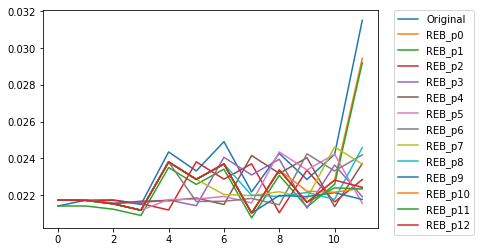

In [149]:
h=Stds
Idx = h.columns
for i in range(len(Idx)):
    plt.plot(h[h.columns[i]], label = Idx[i]) 
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

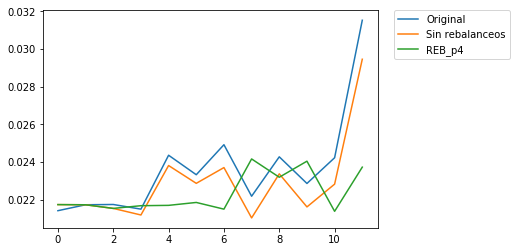

In [51]:
h=Stds
Idx = h.columns
plt.plot(h[h.columns[0]], label = 'Original') 
plt.plot(h[h.columns[1]], label = 'Sin rebalanceos')  
plt.plot(h[h.columns[5]], label = Idx[5]) 
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Sharpe 

In [52]:
Sharpe

,Original,REB_p0,REB_p1,REB_p2,REB_p3,REB_p4,REB_p5,REB_p6,REB_p7,REB_p8,REB_p9,REB_p10,REB_p11,REB_p12
0,0.092910,0.090040,0.092910,0.090040,0.090040,0.090040,0.090040,0.090040,0.090040,0.090040,0.090040,0.090040,0.090040,0.090040
1,0.197493,0.197296,0.196475,0.094709,0.197296,0.197296,0.197296,0.197296,0.197296,0.197296,0.197296,0.197296,0.197296,0.197296
2,0.165105,0.162034,0.160790,0.197493,0.093926,0.162034,0.162034,0.162034,0.162034,0.162034,0.162034,0.162034,0.162034,0.162034
3,0.273676,0.272256,0.272306,0.161770,0.197221,0.094600,0.272256,0.272256,0.272256,0.272256,0.272256,0.272256,0.272256,0.272256
4,0.198717,0.195517,0.195008,0.271700,0.165105,0.197527,0.094903,0.195517,0.195517,0.195517,0.195517,0.195517,0.195517,0.195517
5,0.133472,0.128366,0.127245,0.195549,0.271284,0.165536,0.197594,0.094439,0.128366,0.128366,0.128366,0.128366,0.128366,0.128366
6,0.268004,0.266952,0.266664,0.128406,0.195891,0.273676,0.165913,0.197407,0.096988,0.266952,0.266952,0.266952,0.266952,0.266952
7,0.227149,0.227493,0.227280,0.266392,0.129511,0.195970,0.273627,0.165640,0.202739,0.096736,0.227493,0.227493,0.227493,0.227493
8,0.248017,0.247152,0.247550,0.227255,0.266138,0.130070,0.198717,0.273711,0.166161,0.202559,0.096504,0.247152,0.247152,0.247152
9,0.252721,0.254964,0.254922,0.247519,0.227198,0.265974,0.130882,0.198558,0.272691,0.165990,0.202384,0.098063,0.254964,0.254964


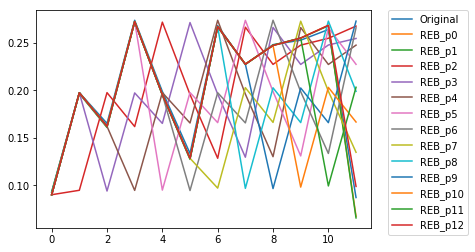

In [53]:
h=Sharpe
Idx = h.columns
for i in range(len(Idx)):
    plt.plot(h[h.columns[i]], label = Idx[i]) 
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

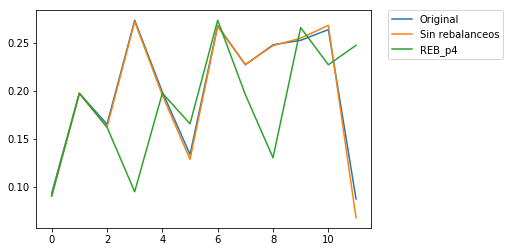

In [54]:
h=Sharpe
Idx = h.columns
plt.plot(h[h.columns[0]], label = 'Original') 
plt.plot(h[h.columns[1]], label = 'Sin rebalanceos')  
plt.plot(h[h.columns[5]], label = Idx[5]) 
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()




###  Comparacion de resultados anual - Medidas de desempeño

In [55]:
anual= pd.DataFrame(columns=['Rendimiento','Volatilidad','Sharpe'])
anual['Rendimiento']=Rends.mean()
anual['Volatilidad']=Stds.mean()
anual['Sharpe']=Sharpe.mean()
anual

,Rendimiento,Volatilidad,Sharpe
Original,0.005486,0.023670,0.200687
REB_p0,0.005256,0.022905,0.198140
REB_p1,0.005194,0.022625,0.197888
REB_p2,0.005208,0.022270,0.200257
REB_p3,0.005042,0.022318,0.194647
REB_p4,0.004929,0.022353,0.187283
REB_p5,0.004926,0.022233,0.189695
REB_p6,0.004900,0.022369,0.187181
REB_p7,0.004656,0.022436,0.176481
REB_p8,0.004913,0.022420,0.187451


### <font color = orange> Propuesta de Rebalanceo

Lo que se busca es un perfil arriesgado, es decir, aumentar el rendimiento sin importar la volatilidad para intentar ganar mas en lugar de tener más segura la inversión.

Para el rebalanceo se toman los siguientes supuestos:
* Se utilizan los mismos números de shares.
* El número de acciones en circulacion es el mismo que el etf.
* Se toman las 10 acciones de cada mes con la mayor rentabilidad.

Encontrando activos con menor volatilidad mensual

In [56]:
selecc =[]
for i in range(narch-1):  # calcula rendimientos mensuales de cada activo.
    g= pd.DataFrame([np.mean(Rend(Agrup[1][i+1][j])) for j in indice], index=indice).dropna()
    g = g.sort_values(by=0)[-10:] # selecciona los 10 con mayor rentabilidad
    selecc.append(list(g.index))
selecc

/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/Users/AnaLaura/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


[['CYS', 'LAZ', 'SBAC', 'NLY', 'JNS', 'RLGY', 'TWO', 'EQIX', 'AMT', 'CIM'],
 ['RE', 'IVZ', 'GEO', 'DLR', 'BOKF', 'CIT', 'WDR', 'COR', 'CXW', 'FAF'],
 ['ALL', 'SPGI', 'DFT', 'PGR', 'BLK', 'CCI', 'EV', 'SBAC', 'AON', 'WLTW'],
 ['JPM',
  'FCNCA',
  'GBCI',
  'BPOP',
  'AMTD',
  'DFT',
  'FFIN',
  'NAVI',
  'PKY',
  'CACC'],
 ['SF', 'FAF', 'CNO', 'MCY', 'FNF', 'EVR', 'TROW', 'WDR', 'AMG', 'AMP'],
 ['BGCP', 'CONE', 'NHI', 'CBOE', 'IRM', 'CCI', 'COR', 'AMT', 'SBAC', 'KMPR'],
 ['UMPQ',
  'AMTD',
  'CFG',
  'CATY',
  'FFIN',
  'MBFI',
  'FDS',
  'TCBI',
  'GBCI',
  'CHFC'],
 ['CCI', 'FAF', 'PRI', 'FNF', 'HHC', 'SBAC', 'RDN', 'MTG', 'SIVB', 'KMPR'],
 ['EVR', 'TROW', 'SBAC', 'MKTX', 'JLL', 'PRI', 'MAC', 'GGP', 'TCO', 'PRAA'],
 ['FNGN', 'COF', 'SYF', 'LPLA', 'WFC', 'DFS', 'BKU', 'TCO', 'VOYA', 'DDR'],
 ['MTB', 'SBNY', 'VLY', 'CFR', 'SF', 'TRV', 'STT', 'BPOP', 'AFSI', 'VR'],
 ['RE', 'CME', 'RYN', 'SPGI', 'FNF', 'LPLA', 'PRAA', 'PGR', 'XL', 'FNGN']]

In [57]:
port=[]
for i in range(narch-1):
    sh = Shares.loc[selecc[i]]
    sh.columns = pd.to_datetime(fechas)
    pr_reb= precios_f[selecc[i]]
    pr_reb = pr_reb.loc[pd.to_datetime(fechas)].T
    T_port = np.sum(sh*pr_reb)/str_to_float(shares)[i]
    port.append(T_port)
port[2]

2017-02-28    6.450498
2017-03-31    5.675872
2017-04-28    5.389442
2017-05-31    5.639194
2017-06-30    5.953238
2017-07-31    6.384405
2017-08-31    6.673240
2017-09-29    6.783730
2017-10-31    7.248747
2017-11-30    7.339349
2017-12-29    6.843147
2018-01-31    7.758061
2018-02-28    8.177118
dtype: float64

In [58]:
NAVm=[]
for i in range(narch-1):
    NAVm.append(port[i][i]) 
NAVm

[2.886454950249644,
 1.4170515817767013,
 5.3894424903617235,
 7.181821472609727,
 1.6506797351807465,
 3.2914152592107575,
 1.1690970798293754,
 2.3759832039772726,
 1.8363472421849076,
 8.425579315186244,
 2.873379883435583,
 3.997778553448277]

In [59]:
RendA= np.mean(Rend(NAVm))
StdA=np.std(Rend(NAVm))
Sharpe=np.mean(Rend(NAVm))-tl[0]/np.std(Rend(NAVm))

In [60]:
anual= pd.DataFrame(columns=['Rendimiento','Volatilidad','Sharpe'])
anual['Rendimiento']=Rends.mean()
anual['Volatilidad']=Stds.mean()
anual['Sharpe']=Sharpe.mean()
anual

,Rendimiento,Volatilidad,Sharpe
Original,0.005486,0.023670,-0.385174
REB_p0,0.005256,0.022905,-0.385174
REB_p1,0.005194,0.022625,-0.385174
REB_p2,0.005208,0.022270,-0.385174
REB_p3,0.005042,0.022318,-0.385174
REB_p4,0.004929,0.022353,-0.385174
REB_p5,0.004926,0.022233,-0.385174
REB_p6,0.004900,0.022369,-0.385174
REB_p7,0.004656,0.022436,-0.385174
REB_p8,0.004913,0.022420,-0.385174


### <font color = orange> Conclusiones

¿Qué paso cuando le movía a los pesos del etf?
¿Qué hubiera pasado si los rebalanceos hubieran sido diferentes? (escenarios).

### BIBLIOGRAFÍAS
- https://www.portafolio.co/economia/finanzas/son-etf-293754

- https://economipedia.com/definiciones/etf-fondos-cotizados.html

- https://www.ishares.com/us/products/239508/#/

- https://www.quandl.com/tools/python

- https://www.selfbank.es/centro-de-ayuda/fondos-de-inversion/que-es-el-ratio-de-sharpe

In [136]:
fig = make_subplots(rows=1, cols=2)

fig.add_trace(go.Scatter(x=fechas,y=Rends_mensual),row=1, col=1)

fig.add_trace(go.Scatter(x=fechas,y=Rends_mensual11),row=1, col=2)


fig.update_layout(height=600, width=800, title_text="Subplots")
fig.show()